In [1]:
import keras
import fastai
from fastai.vision import *
from fastai.metrics import fbeta

import pandas as pd
import numpy as np

import os
import shutil
from pathlib import Path
import tarfile

import matplotlib.pyplot as plt
from PIL import Image

Using TensorFlow backend.


In [20]:
path_raw_data = Path('../data/kaggle/sample/')
files = os.listdir(path_raw_data)
files

['sample_labels.csv', 'sample.zip', 'images']

In [21]:
path_data = path_raw_data/'images'
verify_images(path_data, n_channels=1)
img_files = os.listdir(path_data)

Image ../data/kaggle/sample/images/00029745_001.png has 4 instead of 1 channels
Image ../data/kaggle/sample/images/00013360_000.png has 4 instead of 1 channels
Image ../data/kaggle/sample/images/00004395_000.png has 4 instead of 1 channels
Image ../data/kaggle/sample/images/00005496_000.png has 4 instead of 1 channels
Image ../data/kaggle/sample/images/00002720_004.png has 4 instead of 1 channels
Image ../data/kaggle/sample/images/00000084_000.png has 4 instead of 1 channels
Image ../data/kaggle/sample/images/00007258_000.png has 4 instead of 1 channels
Image ../data/kaggle/sample/images/00006843_000.png has 4 instead of 1 channels
Image ../data/kaggle/sample/images/00014223_009.png has 4 instead of 1 channels
Image ../data/kaggle/sample/images/00001260_000.png has 4 instead of 1 channels
Image ../data/kaggle/sample/images/00002543_000.png has 4 instead of 1 channels
Image ../data/kaggle/sample/images/00012139_000.png has 4 instead of 1 channels
Image ../data/kaggle/sample/images/00002

In [24]:
img_files[:5], len(img_files)

(['00021006_018.png',
  '00011485_004.png',
  '00019484_005.png',
  '00001301_021.png',
  '00010120_020.png'],
 5584)

In [106]:
df_labels = pd.read_csv(path_raw_data/"sample_labels.csv")
print(df_labels.head(), df_labels.shape)
df_labels = df_labels.loc[df_labels['Image Index'].isin(img_files)]
# df_labels = df_labels.iloc[:200]
print(df_labels.shape)

        Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                3056                 2544           

In [107]:
tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=0.02)

basic_block = (ImageItemList
                .from_df(df_labels,
                         path=path_data)
                .random_split_by_pct(0.2)
                .label_from_df(label_delim='|'))

db_xrays = (basic_block
            .transform(tfms, 
                       size=64) 
            .databunch(bs=32))

db_xrays.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (4467 items)
x: ImageItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultiCategoryList
Emphysema;Infiltration;Pleural_Thickening;Pneumothorax,Cardiomegaly;Emphysema,No Finding,Atelectasis,Cardiomegaly;Edema;Effusion
Path: ../data/kaggle/sample/images;

Valid: LabelList (1116 items)
x: ImageItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultiCategoryList
Consolidation;Infiltration,Emphysema,Effusion;Infiltration,No Finding,Atelectasis
Path: ../data/kaggle/sample/images;

Test: None

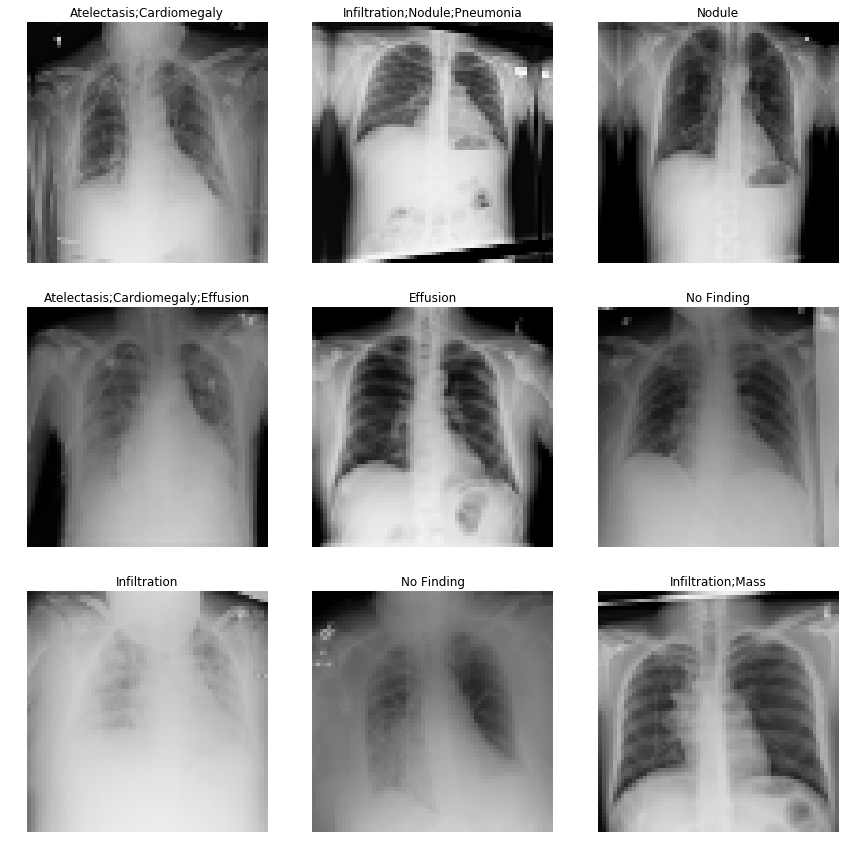

In [108]:
db_xrays.show_batch(3)

In [109]:
def accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(-1).long()
    return (input==targs).float().mean()

model = create_cnn(data=db_xrays, 
                   arch=models.densenet121, 
                   metrics=[fbeta])

/opt/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [110]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-02


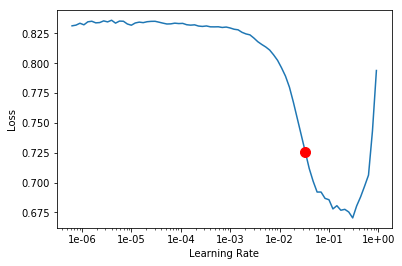

In [111]:
model.recorder.plot()

In [73]:
# x,y = next(iter(db_xrays.valid_dl))
# y
# # list(zip(db_xrays.classes, y[0]))

In [112]:
model.fit_one_cycle(cyc_len=5, max_lr=3.3e-2)

epoch,train_loss,valid_loss,fbeta
1,0.264039,0.229210,0.502206
2,0.222878,0.210360,0.580590
3,0.219223,0.219735,0.545536
4,0.209446,0.201740,0.586439
5,0.201695,0.197662,0.591589


In [134]:
model.save('stage1')

In [143]:
model.load('stage1')
model.unfreeze()
# model.freeze_to(100)
# model.freeze()

In [140]:
model.data = (basic_block
            .transform(tfms, 
                       size=100) 
            .databunch(bs=20))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06


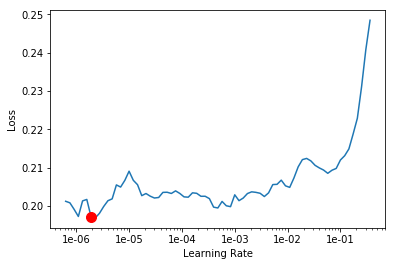

In [141]:
model.lr_find()
model.recorder.plot()

In [144]:
model.fit_one_cycle(cyc_len=5, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,fbeta
1,0.201796,0.202957,0.583518
2,0.203708,0.208164,0.587136
3,0.199574,0.195937,0.589914
4,0.192358,0.195101,0.593595
5,0.191924,0.195174,0.595510


In [146]:
model.save('stage2')